In [4]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import KFold
import pandas as pd



# Load KMNIST dataset
dataset_name = "kmnist"
(ds_train, ds_test), ds_info = tfds.load(dataset_name, split=['train', 'test'], as_supervised=True, with_info=True)

# Convert dataset to NumPy arrays
x_train = np.array([img.numpy() for img, label in ds_train])
y_train = np.array([label.numpy() for img, label in ds_train])
x_test = np.array([img.numpy() for img, label in ds_test])
y_test = np.array([label.numpy() for img, label in ds_test])

# Normalize images to [0,1] range
x_train, x_test = x_train / 255.0, x_test / 255.0

# Flatten images (28x28 → 784)
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# Convert labels to categorical (one-hot encoding)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")

Train shape: (60000, 784), Test shape: (10000, 784)


In [5]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(784,)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model


In [6]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def cross_validate_model(optimizer_name, learning_rate=0.001, weight_decay=0.0, epochs=10):
    val_accuracies = []
    
    for train_idx, val_idx in kf.split(x_train):
        x_train_fold, x_val_fold = x_train[train_idx], x_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        model = build_model()
        
        # Select optimizer
        if optimizer_name == "Adam":
            optimizer = keras.optimizers.Adam(learning_rate)
        elif optimizer_name == "RMSprop":
            optimizer = keras.optimizers.RMSprop(learning_rate)
        elif optimizer_name == "AdamW":
            optimizer = keras.optimizers.AdamW(learning_rate, weight_decay)
        else:
            raise ValueError("Invalid optimizer name!")

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(x_train_fold, y_train_fold, epochs=epochs, validation_data=(x_val_fold, y_val_fold), verbose=0)
        
        val_accuracies.append(history.history['val_accuracy'][-1])

    avg_val_accuracy = np.mean(val_accuracies)
    print(f"{optimizer_name} - Average Validation Accuracy (5-fold): {avg_val_accuracy:.4f}")
    return avg_val_accuracy

# Hyperparameter tuning
optimizers = ["Adam", "RMSprop", "AdamW"]
learning_rates = [0.001, 0.0005]
weight_decays = [0.001, 0.0005]
results_list = []

best_val_acc = 0
best_params = {}

for optimizer in optimizers:
    if optimizer == "AdamW":
        for lr in learning_rates:
            for wd in weight_decays:
                print(f"\nTraining with {optimizer}, Learning Rate: {lr}, Weight Decay: {wd}...\n")
                avg_val_acc = cross_validate_model(optimizer, learning_rate=lr, weight_decay=wd, epochs=10)
                
                results_list.append([optimizer, lr, wd, avg_val_acc])

                
                if avg_val_acc > best_val_acc:
                    best_val_acc = avg_val_acc
                    best_params = {"optimizer": optimizer, "learning_rate": lr, "weight_decay": wd}
    else:
        for lr in learning_rates:
            print(f"\nTraining with {optimizer}, Learning Rate: {lr}...\n")
            avg_val_acc = cross_validate_model(optimizer, learning_rate=lr, epochs=10)
            
            results_list.append([optimizer, lr, 0.0, avg_val_acc])  

            
            if avg_val_acc > best_val_acc:
                best_val_acc = avg_val_acc
                best_params = {"optimizer": optimizer, "learning_rate": lr, "weight_decay": 0.0}



# Print best hyperparameters
print(f"\nBest Hyperparameters: {best_params} with Validation Accuracy: {best_val_acc:.4f}")

# Train final model with best hyperparameters
final_optimizer = best_params["optimizer"]
final_lr = best_params["learning_rate"]
final_wd = best_params["weight_decay"]

print(f"\nTraining final model with {final_optimizer} (LR: {final_lr}, Weight Decay: {final_wd})...\n")

model = build_model()
if final_optimizer == "Adam":
    optimizer = keras.optimizers.Adam(final_lr)
elif final_optimizer == "RMSprop":
    optimizer = keras.optimizers.RMSprop(final_lr)
elif final_optimizer == "AdamW":
    optimizer = keras.optimizers.AdamW(final_lr, final_wd)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=2)
training_time = time.time() - start_time

# Get final accuracy
final_test_acc = history.history['val_accuracy'][-1]
print(f"\n{final_optimizer} - Final Test Accuracy: {final_test_acc:.4f}\n")




Training with Adam, Learning Rate: 0.001...



c:\Users\karti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Adam - Average Validation Accuracy (5-fold): 0.9498

Training with Adam, Learning Rate: 0.0005...

Adam - Average Validation Accuracy (5-fold): 0.9487

Training with RMSprop, Learning Rate: 0.001...

RMSprop - Average Validation Accuracy (5-fold): 0.9508

Training with RMSprop, Learning Rate: 0.0005...

RMSprop - Average Validation Accuracy (5-fold): 0.9512

Training with AdamW, Learning Rate: 0.001, Weight Decay: 0.001...

AdamW - Average Validation Accuracy (5-fold): 0.9502

Training with AdamW, Learning Rate: 0.001, Weight Decay: 0.0005...

AdamW - Average Validation Accuracy (5-fold): 0.9516

Training with AdamW, Learning Rate: 0.0005, Weight Decay: 0.001...

AdamW - Average Validation Accuracy (5-fold): 0.9475

Training with AdamW, Learning Rate: 0.0005, Weight Decay: 0.0005...

AdamW - Average Validation Accuracy (5-fold): 0.9496

Best Hyperparameters: {'optimizer': 'AdamW', 'learning_rate': 0.001, 'weight_decay': 0.0005} with Validation Accuracy: 0.9516

Training final model wit

In [7]:

# Save results to CSV
df = pd.DataFrame(results_list, columns=["Optimizer", "Learning Rate", "Weight Decay", "Validation Accuracy",])
df.to_csv("optimizer_results.csv", index=False)

optimiser_result = pd.read_csv("optimizer_results.csv")
optimiser_result.head(12)

Optimizer  Learning Rate  Weight Decay  Validation Accuracy
0      Adam         0.0010        0.0000             0.949767
1      Adam         0.0005        0.0000             0.948717
2   RMSprop         0.0010        0.0000             0.950767
3   RMSprop         0.0005        0.0000             0.951233
4     AdamW         0.0010        0.0010             0.950150
5     AdamW         0.0010        0.0005             0.951600
6     AdamW         0.0005        0.0010             0.947483
7     AdamW         0.0005        0.0005             0.949583

In [8]:
# Append final optimizer result to CSV
final_result = pd.DataFrame([[final_optimizer, final_lr, 0.0, 0.0, final_test_acc]], 
                            columns=["Optimizer", "Learning Rate","weight_decays", "Validation Accuracy","Test Accuracy"])
final_result.to_csv("Best_optimizer_results.csv", mode="a", header=False, index=False)

Bestoptimiser_result = pd.read_csv("Best_optimizer_results.csv")
Bestoptimiser_result.head()

AdamW  0.001  0.0  0.0.1  0.8949000239372253
0  AdamW  0.001  0.0    0.0              0.8919

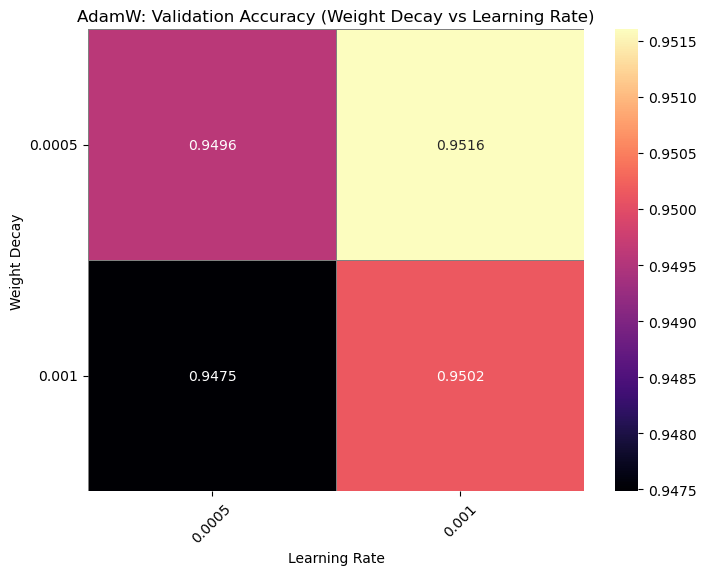

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert results into DataFrame
df_results = pd.DataFrame(results_list, columns=["Optimizer", "Learning Rate", "Weight Decay", "Validation Accuracy"])

# 🔥 Create a new "Optimizer+WD" column to differentiate AdamW weight decay values
df_results["Optimizer_WD"] = df_results.apply(
    lambda row: f"{row['Optimizer']} (WD={row['Weight Decay']})" if row["Optimizer"] == "AdamW" else row["Optimizer"], axis=1
)

# 🔥 First Heatmap: Validation Accuracy (All Optimizers & Weight Decays)
heatmap_data = df_results.pivot(index="Optimizer_WD", columns="Learning Rate", values="Validation Accuracy")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5, linecolor='gray')

plt.title("Validation Accuracy Heatmap (All Optimizers & Weight Decays)")
plt.xlabel("Learning Rate")
plt.ylabel("Optimizer")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# 🔥 Second Heatmap: AdamW (Weight Decay vs Learning Rate)
df_adamw = df_results[df_results["Optimizer"] == "AdamW"]
heatmap_wd = df_adamw.pivot(index="Weight Decay", columns="Learning Rate", values="Validation Accuracy")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_wd, annot=True, cmap="magma", fmt=".4f", linewidths=0.5, linecolor='gray')

plt.title("AdamW: Validation Accuracy (Weight Decay vs Learning Rate)")
plt.xlabel("Learning Rate")
plt.ylabel("Weight Decay")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


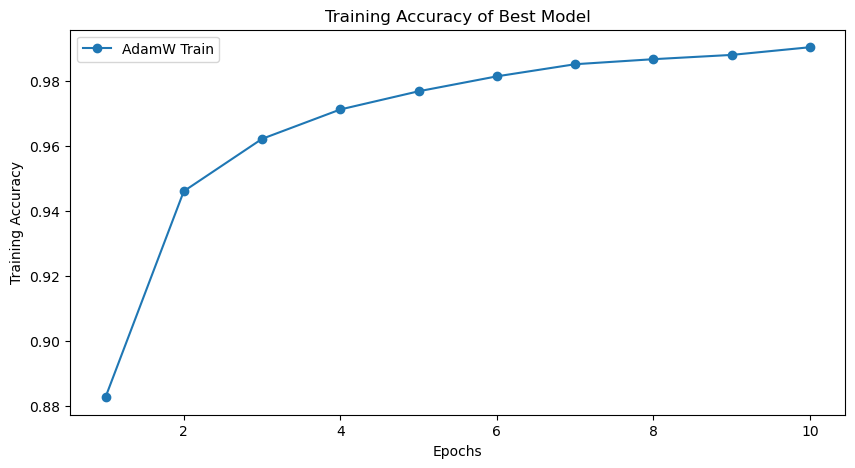

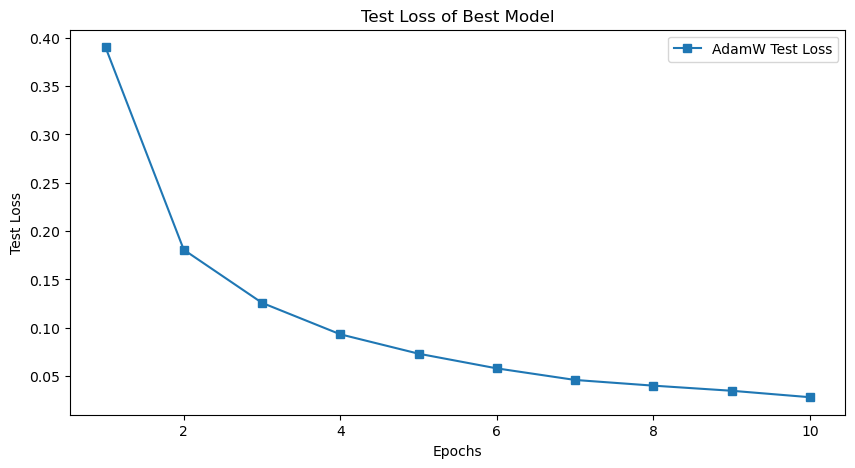

In [11]:


epochs_range = range(1, 11)

# Plot Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, history.history['accuracy'], label=f"{final_optimizer} Train", marker="o")  
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.title("Training Accuracy of Best Model")
plt.show()

# Plot Test Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, history.history['loss'], label=f"{final_optimizer} Test Loss", marker="s")  # Using 'loss' instead of 'val_loss'
plt.xlabel("Epochs")
plt.ylabel("Test Loss")
plt.legend()
plt.title("Test Loss of Best Model")
plt.show()
